In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

C:\Users\xinyu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
biden = pd.read_csv('biden.csv', sep=',')

# (a)

In [3]:
y = biden['biden'].values
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [4]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import mean_squared_error

In [5]:
hit_tree = DecisionTreeRegressor()
hit_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

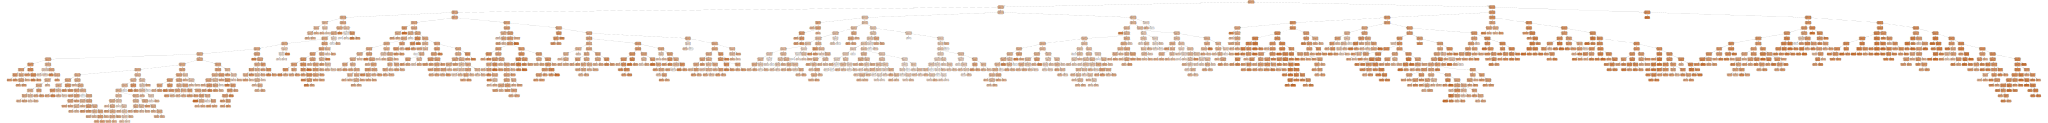

In [6]:
hit_tree_viz = export_graphviz(
    hit_tree,
    out_file=None,
    feature_names = ['female', 'age', 'educ', 'dem', 'rep'],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz)
graph.render('hit_tree_viz')
graph

In [7]:
y_pred = hit_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 692.9709874281203


### Basically, the model tell us that party 1) affliation matters, if people are democrats they like Biden better. If people are republican, they like Biden less than ordinary. 2) Generation Matters. The older generation like Biden more than younger generation.  3) Geneder matters, in Democrat, women love Biden better, while in Repulic women love Biden slightly better. 

# (b)

In [8]:
for depth in range(1,20):
    tree_clf = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5)
    tree_clf.fit(X_train, y_train)
    y_pred2 = tree_clf.predict(X_test)
    MSE2 = mean_squared_error(y_test, y_pred2)
    print('MSE for test set', depth, ' is', MSE2)

MSE for test set 1  is 420.0224529349668
MSE for test set 2  is 400.06539818418173
MSE for test set 3  is 396.1937146321307
MSE for test set 4  is 404.59602362340974
MSE for test set 5  is 411.80592737244535
MSE for test set 6  is 420.5463039149151
MSE for test set 7  is 435.76906119360757
MSE for test set 8  is 464.8931449707398
MSE for test set 9  is 460.0757513704717
MSE for test set 10  is 468.3329719590837
MSE for test set 11  is 470.9931084565257
MSE for test set 12  is 478.69286911070185
MSE for test set 13  is 477.16079264127467
MSE for test set 14  is 480.25506771976944
MSE for test set 15  is 481.850195737981
MSE for test set 16  is 482.8423688503198
MSE for test set 17  is 480.6980083436862
MSE for test set 18  is 482.81587206375985
MSE for test set 19  is 480.7245051302462


### It seems that tree with max_dept = 3 results in the lowest MSE 396.1937146321307

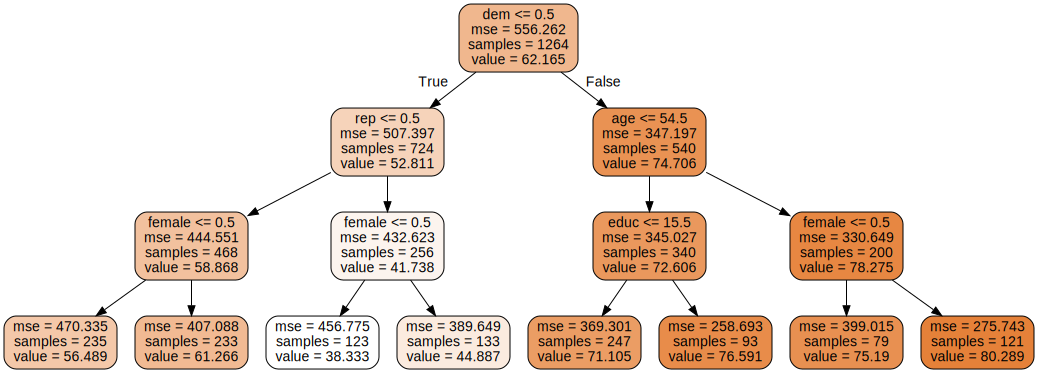

In [9]:
hit_tree2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)
hit_tree2.fit(X_train, y_train)
hit_tree_viz2 = export_graphviz(
    hit_tree2,
    out_file=None,
    feature_names = ['female', 'age', 'educ', 'dem', 'rep'],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz2)
graph.render('hit_tree_viz')
graph

### This tree keeps the same prediction of important features, party affliation, age and gender, but it cut down some non-necessary feature, thus yiled a smaller MSE compared to original large tree.

# (c)

In [10]:
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import seaborn as sb
print(biden.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1807 entries, 0 to 1806
Data columns (total 6 columns):
biden     1807 non-null int64
female    1807 non-null int64
age       1807 non-null int64
educ      1807 non-null int64
dem       1807 non-null int64
rep       1807 non-null int64
dtypes: int64(6)
memory usage: 84.8 KB
None


In [11]:
# n_estimators is how many samples from the data to take (the number of trees)
# max_samples is the maximum number of observations to include in each bootstrapped data sample
hit_tree_bagging = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                                 max_samples=100, bootstrap=True, oob_score=True,
                                 random_state=15)
hit_tree_bagging.fit(X, y)
y_pred_bagging = hit_tree_bagging.oob_prediction_
MSE3 = mean_squared_error(y, y_pred_bagging)
print('MSE_Bagging=', MSE3)

MSE_Bagging= 406.0005583949261


In [12]:
importances = np.mean([
    tree.feature_importances_ for tree in hit_tree_bagging.estimators_
], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(len(features)):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

1 .  female :  0.4429127039606069
2 .  age :  0.20057625971613363
3 .  dem :  0.19032354439169072
4 .  rep :  0.10602822551257896
5 .  educ :  0.06015926641898977


### Based on the bagging method, we saw that geneder is the must important variable, after than it's age and political affliation.

# (d)

In [13]:
from sklearn.ensemble import RandomForestRegressor
hit_tree4 = RandomForestRegressor(n_estimators=53, max_features=1, bootstrap=True,
                                  oob_score=True, random_state=15)
hit_tree4.fit(X, y)
hit_tree4.score(X, y)
y_pred4 = hit_tree4.oob_prediction_
MSE4 = mean_squared_error(y, y_pred4)
print('For M = 1, MSE =' , MSE4)

For M = 1, MSE = 532.8750579722736


In [14]:
hit_tree5 = RandomForestRegressor(n_estimators=53, max_features=2, bootstrap=True,
                                  oob_score=True, random_state=15)
hit_tree5.fit(X, y)

hit_tree5.score(X, y)
y_pred5 = hit_tree5.oob_prediction_
MSE5 = mean_squared_error(y, y_pred5)
print('For M = 2, MSE =' , MSE5)

For M = 2, MSE = 538.192542935064


In [15]:
hit_tree6 = RandomForestRegressor(n_estimators=53, max_features=3, bootstrap=True,
                                  oob_score=True, random_state=15)
hit_tree6.fit(X, y)

hit_tree6.score(X, y)
y_pred6 = hit_tree6.oob_prediction_
MSE6 = mean_squared_error(y, y_pred6)
print('For M = 3, MSE =' , MSE6)

For M = 3, MSE = 535.7619627008756


### m=1 produce the best MSE in this mode. Though the difference is not siginicant. 

In [16]:
importances = hit_tree4.feature_importances_
std = np.std([tree.feature_importances_ for tree in hit_tree4.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

Feature ranking:
1 .  female :  0.5121750986284854
2 .  age :  0.1924320716293704
3 .  dem :  0.15018054715372878
4 .  rep :  0.12387921818323255
5 .  educ :  0.021333064405182765


### The same results as before, female seems to be the most important variable, age and party affliation follow. 